In [1]:
import os
import os.path as osp
from PIL import Image
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
%load_ext autoreload
%autoreload 2
from skimage.io import imsave, imread
from skimage import img_as_ubyte, img_as_float
import sys
# sys.path.insert(0, '../utils')


In [2]:
def imshow_pair(im, gdt, vmin1=None, vmax1=None, vmin2=None, vmax2=None):
    f, ax = plt.subplots(1, 2, figsize=(8,4))
    np_im = np.asarray(im)
    np_gdt = np.asarray(gdt)
    if len(np_im.shape) == 2:
        if vmin1==None:
            ax[0].imshow(np_im, cmap='gray'),  ax[0].axis('off')
        else:
            ax[0].imshow(np_im, cmap='gray', vmin=vmin1, vmax=vmax1),  ax[0].axis('off')
    else:
        ax[0].imshow(np_im),  ax[0].axis('off')
    if len(np_gdt.shape) == 2:
        if vmin2==None:
            ax[1].imshow(np.asarray(gdt), cmap = 'gray'), ax[1].axis('off')
        else:
            ax[1].imshow(np.asarray(gdt), cmap = 'gray', vmin=vmin2, vmax=vmax2), ax[1].axis('off')
    else:
        ax[1].imshow(np.asarray(gdt)), ax[1].axis('off')
    plt.tight_layout()

In [3]:
import torch
import torchvision.transforms as tr
from utils.get_loaders import get_train_val_loaders
from models.get_model import get_arch

In [4]:
csv_train = 'data/DRIVE/train_av.csv'
csv_val = csv_train.replace('train', 'val')

In [5]:
n_classes=4
label_values=[0, 85, 170, 255]

In [6]:
train_loader, val_loader = get_train_val_loaders(csv_path_train=csv_train, 
                                                 csv_path_val=csv_val, 
                                                 batch_size=2, tg_size=(512,512), 
                                                 label_values=label_values, num_workers=8)

In [7]:
print('* Instantiating a {} model'.format('wnet'))
model = get_arch('big_wnet', n_classes=n_classes)

* Instantiating a wnet model


In [8]:
from utils.model_saving_loading import load_model
model, stats = load_model(model, 'experiments/big_wnet_drive_av/', 'cpu')

In [9]:
criterion = torch.nn.CrossEntropyLoss(reduction='none')

In [10]:
(inputs, labels) = next(iter(val_loader))

In [11]:
from torch.nn import functional as F

In [12]:
logits_aux, logits = model(inputs)
probs = torch.nn.Softmax(dim=1)(logits).detach()

In [13]:
perfect_logits = 100*torch.stack([(labels==0),(labels==1),(labels==2),(labels==3)],dim=1).float()
perfect_probs = torch.nn.Softmax(dim=1)(perfect_logits)

In [14]:
def compute_tv(logits):

    preds = torch.nn.Softmax(dim=1)(logits)

    tv_l = torch.abs(torch.sub(preds, torch.roll(preds, shifts=1, dims=3)))
    tv_r = torch.abs(torch.sub(preds, torch.roll(preds, shifts=-1, dims=3)))
    tv_lu = torch.abs(torch.sub(preds, torch.roll(preds, shifts=(1, 1), dims=(2, 3))))
    tv_rd = torch.abs(torch.sub(preds, torch.roll(preds, shifts=(-1, -1), dims=(2, 3))))

    tv_u = torch.abs(torch.sub(preds, torch.roll(preds, shifts=1, dims=2)))
    tv_d = torch.abs(torch.sub(preds, torch.roll(preds, shifts=-1, dims=2)))
    tv_ru = torch.abs(torch.sub(preds, torch.roll(preds, shifts=(1, -1), dims=(2, 3))))
    tv_dl = torch.abs(torch.sub(preds, torch.roll(preds, shifts=(-1, 1), dims=(2, 3))))
    # take mean across orientations
    tv = torch.mean(torch.stack([tv_l, tv_r, tv_lu, tv_rd, tv_u, tv_d, tv_ru, tv_dl], dim=0), dim=0)

    return tv

In [15]:
def compute_grad(labels):
    grads = []
    for j in range(4):
        tv_l = torch.abs(torch.sub((labels!=j).long(), torch.roll((labels!=j).long(), shifts=1, dims=2)))
        tv_r = torch.abs(torch.sub((labels!=j).long(), torch.roll((labels!=j).long(), shifts=-1, dims=2)))
        tv_u = torch.abs(torch.sub((labels!=j).long(), torch.roll((labels!=j).long(), shifts=1, dims=1)))
        tv_d = torch.abs(torch.sub((labels!=j).long(), torch.roll((labels!=j).long(), shifts=-1, dims=1)))
        # take max across orientations
        this_grad, _ = torch.max(torch.stack([tv_l, tv_r, tv_u, tv_d], dim=0), dim=0)
        grads.append(this_grad)
        
    grad = torch.stack(grads, dim=1)
    
    return grad

In [23]:
grad = compute_grad(labels)
ignore_map = torch.stack([labels == 0, labels == 1, labels == 2, labels == 3], dim=1)

In [17]:
grad.shape, torch.unique(grad)

(torch.Size([2, 4, 512, 512]), tensor([0, 1]))

In [17]:
tv = compute_tv(logits)
tv_perf = compute_tv(perfect_logits)

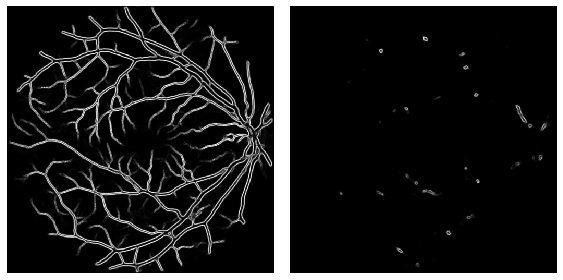

In [18]:
imshow_pair(tv[0,0].detach(), tv[0,1].detach())

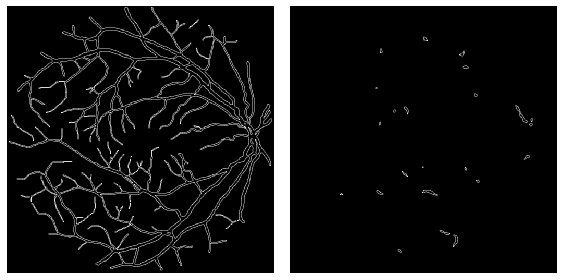

In [19]:
imshow_pair(tv_perf[0,0].detach(), tv_perf[0,1].detach())

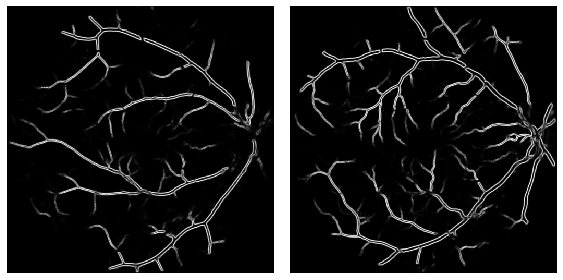

In [20]:
imshow_pair(tv[0,2].detach(), tv[0,3].detach())

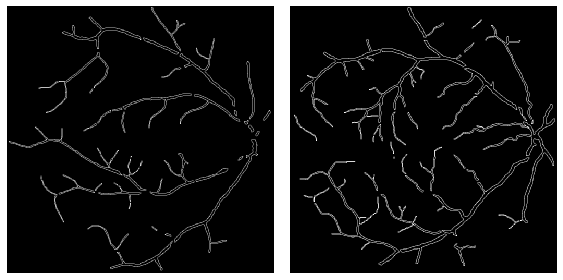

In [21]:
imshow_pair(tv_perf[0,2], tv_perf[0,3])

In [24]:
masked_tv = torch.mul(tv, ignore_map).detach()
masked_tv_perf = torch.mul(tv_perf, ignore_map).detach()

In [25]:
weighted_masked_tv = torch.div(masked_tv, probs)
weighted_masked_tv_perf = torch.div(masked_tv_perf, perfect_probs)

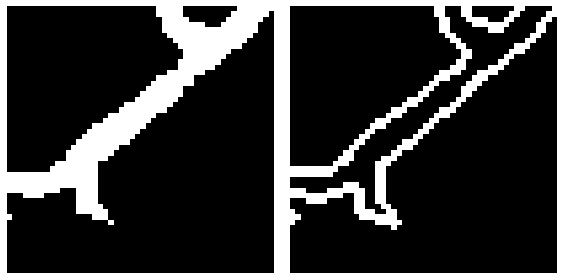

In [26]:
imshow_pair(perfect_probs[0,3,400:450,300:350].detach(), grad[0,3,400:450,300:350].detach())

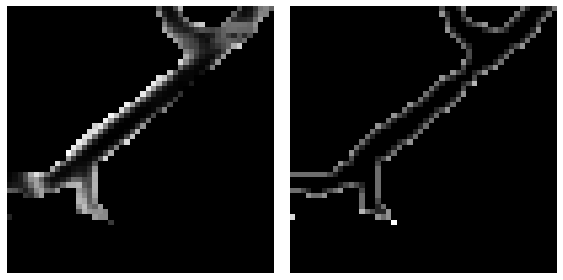

In [27]:
imshow_pair(masked_tv[0,3,400:450,300:350], masked_tv_perf[0,3,400:450,300:350])

In [28]:
error_map = torch.abs(probs-ignore_map.float()).ge(0.5)

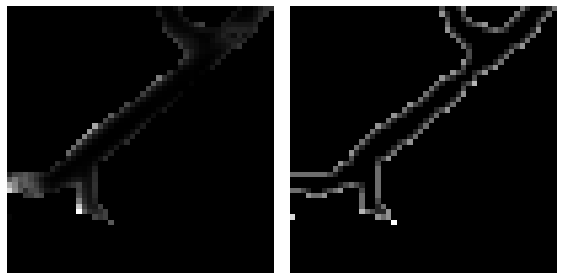

In [29]:
imshow_pair(weighted_masked_tv[0,3,400:450,300:350], weighted_masked_tv_perf[0,3,400:450,300:350])

In [30]:
better_tv = torch.mul(weighted_masked_tv, error_map)

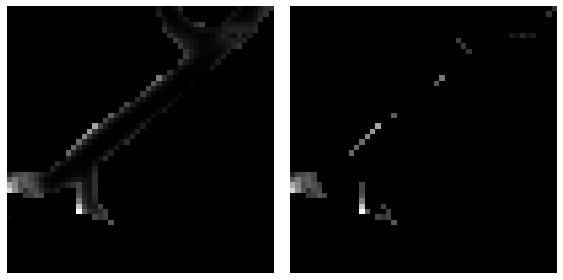

In [31]:
imshow_pair(weighted_masked_tv[0,3,400:450,300:350], better_tv[0,3,400:450,300:350])

In [ ]:
masked_tv_no_grad = torch.mul(masked_tv, (grad==0)).detach()
masked_tv_no_grad_perf = torch.mul(masked_tv_perf, (grad==0)).detach()

weighted_masked_tv_no_grad = torch.mul(weighted_masked_tv, (grad==0)).detach()
weighted_masked_tv_no_grad_perf = torch.mul(weighted_masked_tv_perf, (grad==0)).detach()

In [ ]:
masked_tv_no_grad[0,3,400:450,300:350].mean(), masked_tv_no_grad_perf[0,3,400:450,300:350].mean()

In [ ]:
weighted_masked_tv_no_grad[0,3,400:450,300:350].mean(), weighted_masked_tv_no_grad_perf[0,3,400:450,300:350].mean()

In [ ]:
imshow_pair(masked_tv_no_grad[0,3,400:450,300:350], masked_tv_no_grad_perf[0,3,400:450,300:350], 
            vmin1=0,vmax1=1,vmin2=0,vmax2=1)

In [ ]:
imshow_pair(weighted_masked_tv_no_grad[0,3,400:450,300:350], weighted_masked_tv_no_grad_perf[0,3,400:450,300:350], 
            vmin1=0,vmax1=1,vmin2=0,vmax2=1)

In [ ]:
class MaskedTV(torch.nn.Module):
    def __init__(self, ignore_background=False, sqrt=False, reduction='mean'):
        super(MaskedTV, self).__init__()
        self.reduction = reduction
        self.sqrt = sqrt
        self.ignore_background = ignore_background

    def compute_tv(self, logits):

        preds = torch.nn.Softmax(dim=1)(logits)

        tv_l = torch.abs(torch.sub(preds, torch.roll(preds, shifts=1, dims=3)))
        tv_r = torch.abs(torch.sub(preds, torch.roll(preds, shifts=-1, dims=3)))
        tv_lu = torch.abs(torch.sub(preds, torch.roll(preds, shifts=(1, 1), dims=(2, 3))))
        tv_rd = torch.abs(torch.sub(preds, torch.roll(preds, shifts=(-1, -1), dims=(2, 3))))

        tv_u = torch.abs(torch.sub(preds, torch.roll(preds, shifts=1, dims=2)))
        tv_d = torch.abs(torch.sub(preds, torch.roll(preds, shifts=-1, dims=2)))
        tv_ru = torch.abs(torch.sub(preds, torch.roll(preds, shifts=(1, -1), dims=(2, 3))))
        tv_dl = torch.abs(torch.sub(preds, torch.roll(preds, shifts=(-1, 1), dims=(2, 3))))
        # take mean across orientations
        tv = torch.mean(torch.stack([tv_l, tv_r, tv_lu, tv_rd, tv_u, tv_d, tv_ru, tv_dl], dim=0), dim=0)

        return tv
    
    def compute_grad(self, labels):
        grads = []
        for j in range(4):
            tv_l = torch.abs(torch.sub((labels!=j).long(), torch.roll((labels!=j).long(), shifts=1, dims=2)))
            tv_r = torch.abs(torch.sub((labels!=j).long(), torch.roll((labels!=j).long(), shifts=-1, dims=2)))
            tv_u = torch.abs(torch.sub((labels!=j).long(), torch.roll((labels!=j).long(), shifts=1, dims=1)))
            tv_d = torch.abs(torch.sub((labels!=j).long(), torch.roll((labels!=j).long(), shifts=-1, dims=1)))
            # take max across orientations
            this_grad, _ = torch.max(torch.stack([tv_l, tv_r, tv_u, tv_d], dim=0), dim=0)
            grads.append(this_grad)

        grad = torch.stack(grads, dim=1)

        return grad
    def forward(self, logits, labels, **kwargs):
        # assumes logits is bs x n_classes H x W,
        #         labels is bs x H x W containing integer values in [0,...,n_classes-1]
        
        grad = self.compute_grad(labels)
        ignore_map = torch.stack([labels == 0, labels == 1, labels == 2, labels == 3], dim=1)
        tv = self.compute_tv(logits)
        masked_tv = torch.mul(tv, ignore_map)
        if self.sqrt:
            masked_tv = torch.div(masked_tv, torch.sqrt(torch.nn.Softmax(dim=1)(logits)))
        else:
            masked_tv = torch.div(masked_tv, torch.nn.Softmax(dim=1)(logits))
        masked_tv = torch.mul(masked_tv, (grad==0))
        
        
        if self.ignore_background:
            masked_tv = masked_tv[:, 1:, ...]
            ignore_map = ignore_map[:, 1:, ...]
        if self.reduction == 'mean':  # 1 value for the entire batch
            mean_per_elem_per_class = (masked_tv.sum(dim=(-2, -1)) / ignore_map.sum(dim=(-2, -1)))
            return mean_per_elem_per_class.mean()
        elif self.reduction == 'none':  # n_classes values per element in batch
            return masked_tv
        else:
            sys.exit('not a valid reduction scheme')

In [ ]:
criterion  = MaskedTV(reduction='none',ignore_background=False)

In [ ]:
tv_loss  = criterion(logits, labels)
tv_loss.mean().item(), tv_loss.max().item()

In [ ]:
tv_loss_perfect  = criterion(perfect_logits, labels)
tv_loss_perfect.mean().item(), tv_loss_perfect.max().item()

In [ ]:
imshow_pair(probs[0,3,400:450,300:350], tv_loss[0,3,400:450,300:350].detach(), 
            vmin1=0,vmax1=1,vmin2=0,vmax2=1)

In [ ]:
imshow_pair(perfect_probs[0,3,400:450,300:350], tv_loss_perfect[0,3,400:450,300:350].detach(), 
            vmin1=0,vmax1=1,vmin2=0,vmax2=1)

In [ ]:
criterion  = MaskedTV(ignore_background=False)
criterion(logits, labels).item(), criterion(perfect_logits, labels).item()

In [ ]:
criterion  = MaskedTV(ignore_background=False, sqrt=True)
criterion(logits, labels).item(), criterion(perfect_logits, labels).item()

In [ ]:
criterion  = MaskedTV(ignore_background=True)
criterion(logits, labels).item(), criterion(perfect_logits, labels).item()